In [1]:
from astropy import units as u
from astropy.cosmology import LambdaCDM
from astropy.constants import L_sun, c
from scipy.special import gamma, gammaincc, hyp2f1
from scipy.integrate import quad
from scipy import optimize
import matplotlib as mpl
mpl.use('pdf')

In [2]:
Data = pd.read_csv('results27_14_8_55_72.csv', index_col='specid')
Data = Data[(Data['bmag'] > 0)  & (Data['z_helio']>0)]

cosmo = LambdaCDM(H0=70, Om0=0.3, 
                  Ode0=0.7)

def D_C(z):
    return cosmo.comoving_distance(z).value

def D_L(z):
    return cosmo.luminosity_distance(z).value
Data['D C/Mpc'] = Data['z_helio'].map(D_C)
Data['D L/Mpc'] = Data['z_helio'].map(D_L)
Data.columns = [idx.replace('_', ' ') for idx in Data.columns]

In [3]:
L0 = L_sun.to(u.erg/u.s).value
D_H_in_10pc = ((c/cosmo.H0).to(u.pc)/(10 * u.pc)).value
A = hyp2f1(1/3, 1/2, 4/3, -3/7)
B = 17046 *(np.pi/180)**2
def Mb(bmag, z):
    K = 2.6 * z + 4.3 * z ** 2
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    mu = 5 * np.log10(D_L)
    return bmag - mu - K

Data['Mb'] = list(map(Mb, *Data[['bmag', 'z_helio']].values.T))
def Mb_to_L(M):
    return 10 ** ((M - 4.54)/(-2.5)) #* L_sun.to(u.erg/u.s).value
Data['L rel to sun'] = Data['Mb'].map(Mb_to_L)
A = hyp2f1(1/3, 1/2, 4/3, -3/7)
B = 17046 *(np.pi/180)**2
def my_dVdz(z):
    param = 1+z
    return B * 10/7 * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) ** 2 / np.sqrt(3/10 *param **3 + 7/10)

Data.loc[:, 'dVdz'] = Data['z_helio'].map(my_dVdz)

In [4]:
A = hyp2f1(1/3, 1/2, 4/3, -3/7)
B = 17046 *(np.pi/180)**2
def my_dVdz(z):
    param = 1+z
    return B * 10/7 * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) ** 2 / np.sqrt(3/10 *param **3 + 7/10)

In [5]:
data = Data[Data['z_helio'] < .4][['z_helio', 'bmag', 'Mb', 'L rel to sun', 'dVdz']]

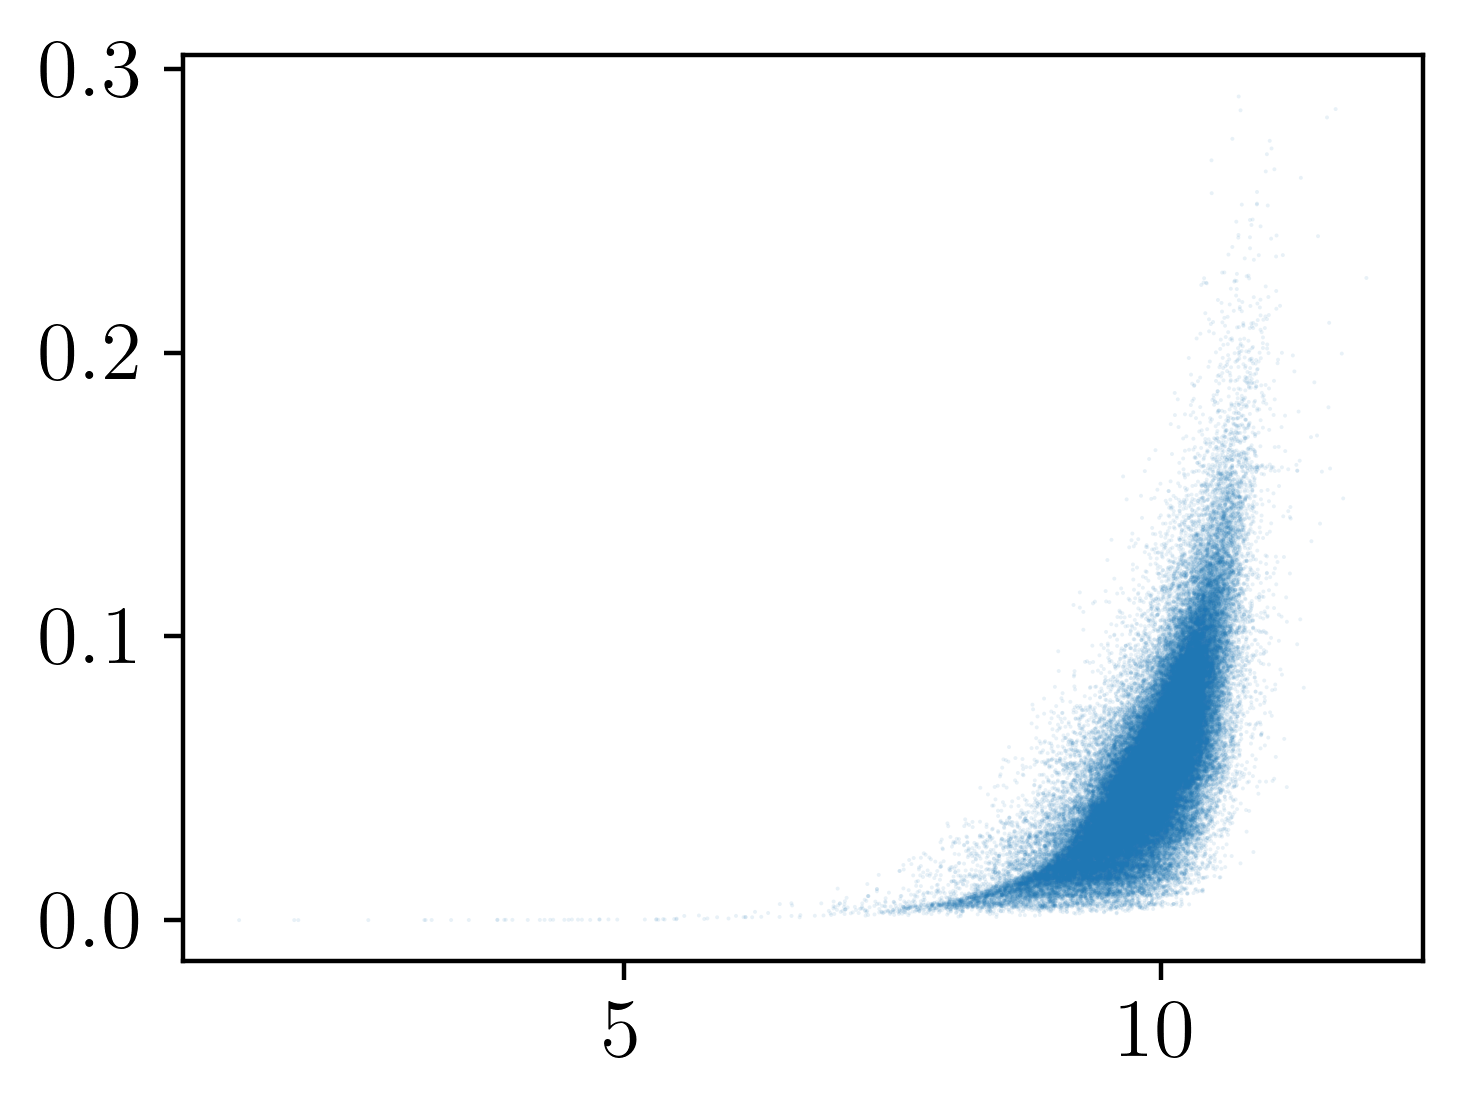

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.scatter(np.log10(data['L rel to sun'].values),data['z_helio'].values, s =.5, alpha=0.1, ec='none')
fig

area: $17046$ $\deg^2$

In [12]:
def phi(L, alpha, L_star):
    return (L/L_star) ** alpha * np.exp(-L/L_star)
def p(L, dVdz, alpha, L_star):
    return phi(L, alpha, L_star) * dVdz

D_H_in_10pc = ((c/cosmo.H0).to(u.pc)/(10 * u.pc)).value
def L_max(z):
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    return 10 ** ((4.54 - 18 + 5 * np.log10(D_L) \
    + 2.6 * z + 4.3 * z ** 2)/2.5)

def L_range(z):
    return [0, L_max(z)]
def int_term(alpha, L_star):
    return quad(lambda z: (1 - gammaincc(alpha+1, L_max(z)/L_star) ) * my_dVdz(z), 0, 1.11172022586983898)[0]

In [13]:
n = len(data)

data.loc[:, 'log dVdz'] = data['dVdz'].map(np.log10)
log10e = np.log10(np.e)
sum_log_V = sum(data[data['bmag']< 18]['log dVdz'].values)
sum_log_L = sum(data[data['bmag']< 18]['L rel to sun'].map(np.log10))
sum_L = sum(data[data['bmag']< 18]['L rel to sun'])

$N!\approx \sqrt{2\pi N}\left(\dfrac{N}{e}\right)^N$

In [14]:
def P_obs(alpha, L_star):
    return -n * (np.log10(L_star) * (alpha + 1) + gamma(alpha+1)) + \
                sum_log_V + alpha * sum_log_L - log10e * sum_L / L_star
constant = -1/2 * np.log10(2 * np.pi)
def P(theta):
    alpha, L_star, N = theta
    return -((1/2 + N) * np.log10(N) + (-1/2 - N + n) * np.log10(N - n) + \
    (-1/2 - n) * np.log10(n) + constant + P_obs(alpha, L_star) + (N - n) * np.log10(int_term(alpha, L_star)))


In [15]:
data.loc[:, 'log L'] = data['L rel to sun'].map(np.log10)

In [16]:
np.save('log L data', data['log L'].values)

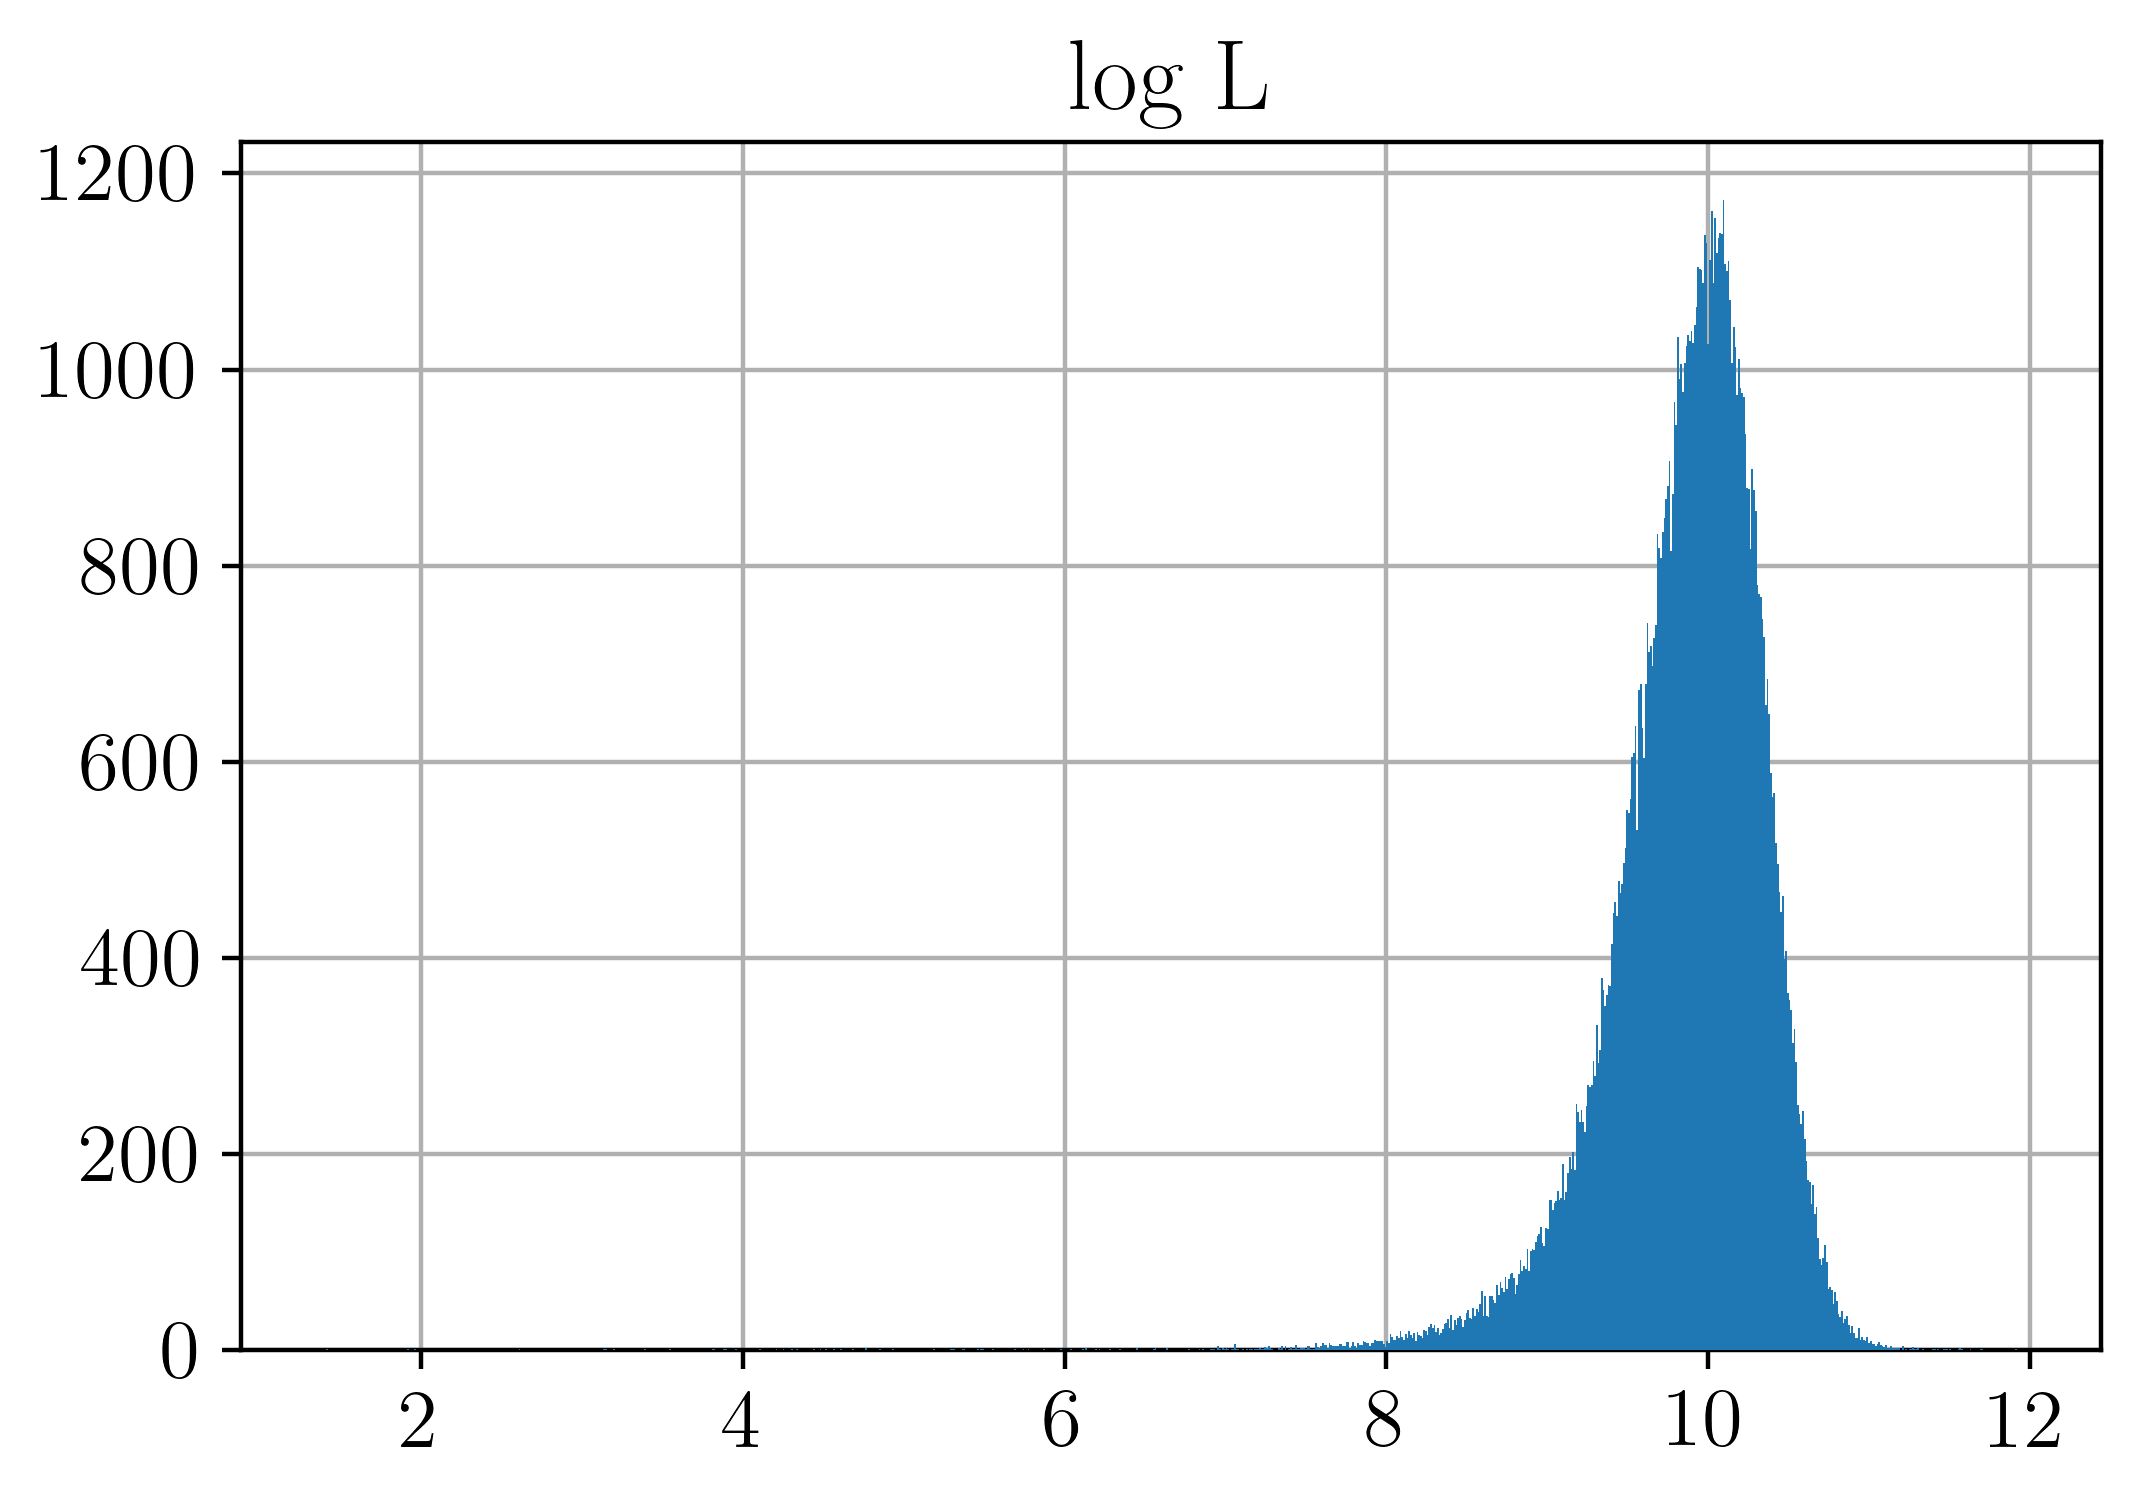

In [17]:
data[['log L']].hist(bins=1000, zorder=10)
plt.gcf()

In [19]:
optimize.minimize(P, [-0.1, 1e10, n * 1e5], bounds=[(-0.99, 1), (1e8, 1e13), (n * 1.1, n * 1e10)], method='Nelder-Mead' )

 final_simplex: (array([[-7.83280781e-02,  5.27617193e+09,  1.71416326e+08],
       [-7.83280781e-02,  5.27617193e+09,  1.71416326e+08],
       [-7.83280781e-02,  5.27617193e+09,  1.71416326e+08],
       [-7.83280781e-02,  5.27617193e+09,  1.71416326e+08]]), array([1091883.67796044, 1091883.67796068, 1091883.67796068,
       1091883.67796093]))
           fun: 1091883.6779604433
       message: 'Optimization terminated successfully.'
          nfev: 486
           nit: 238
        status: 0
       success: True
             x: array([-7.83280781e-02,  5.27617193e+09,  1.71416326e+08])

In [55]:
def normalize(a):
    return (a - np.mean(a))/np.std(a)

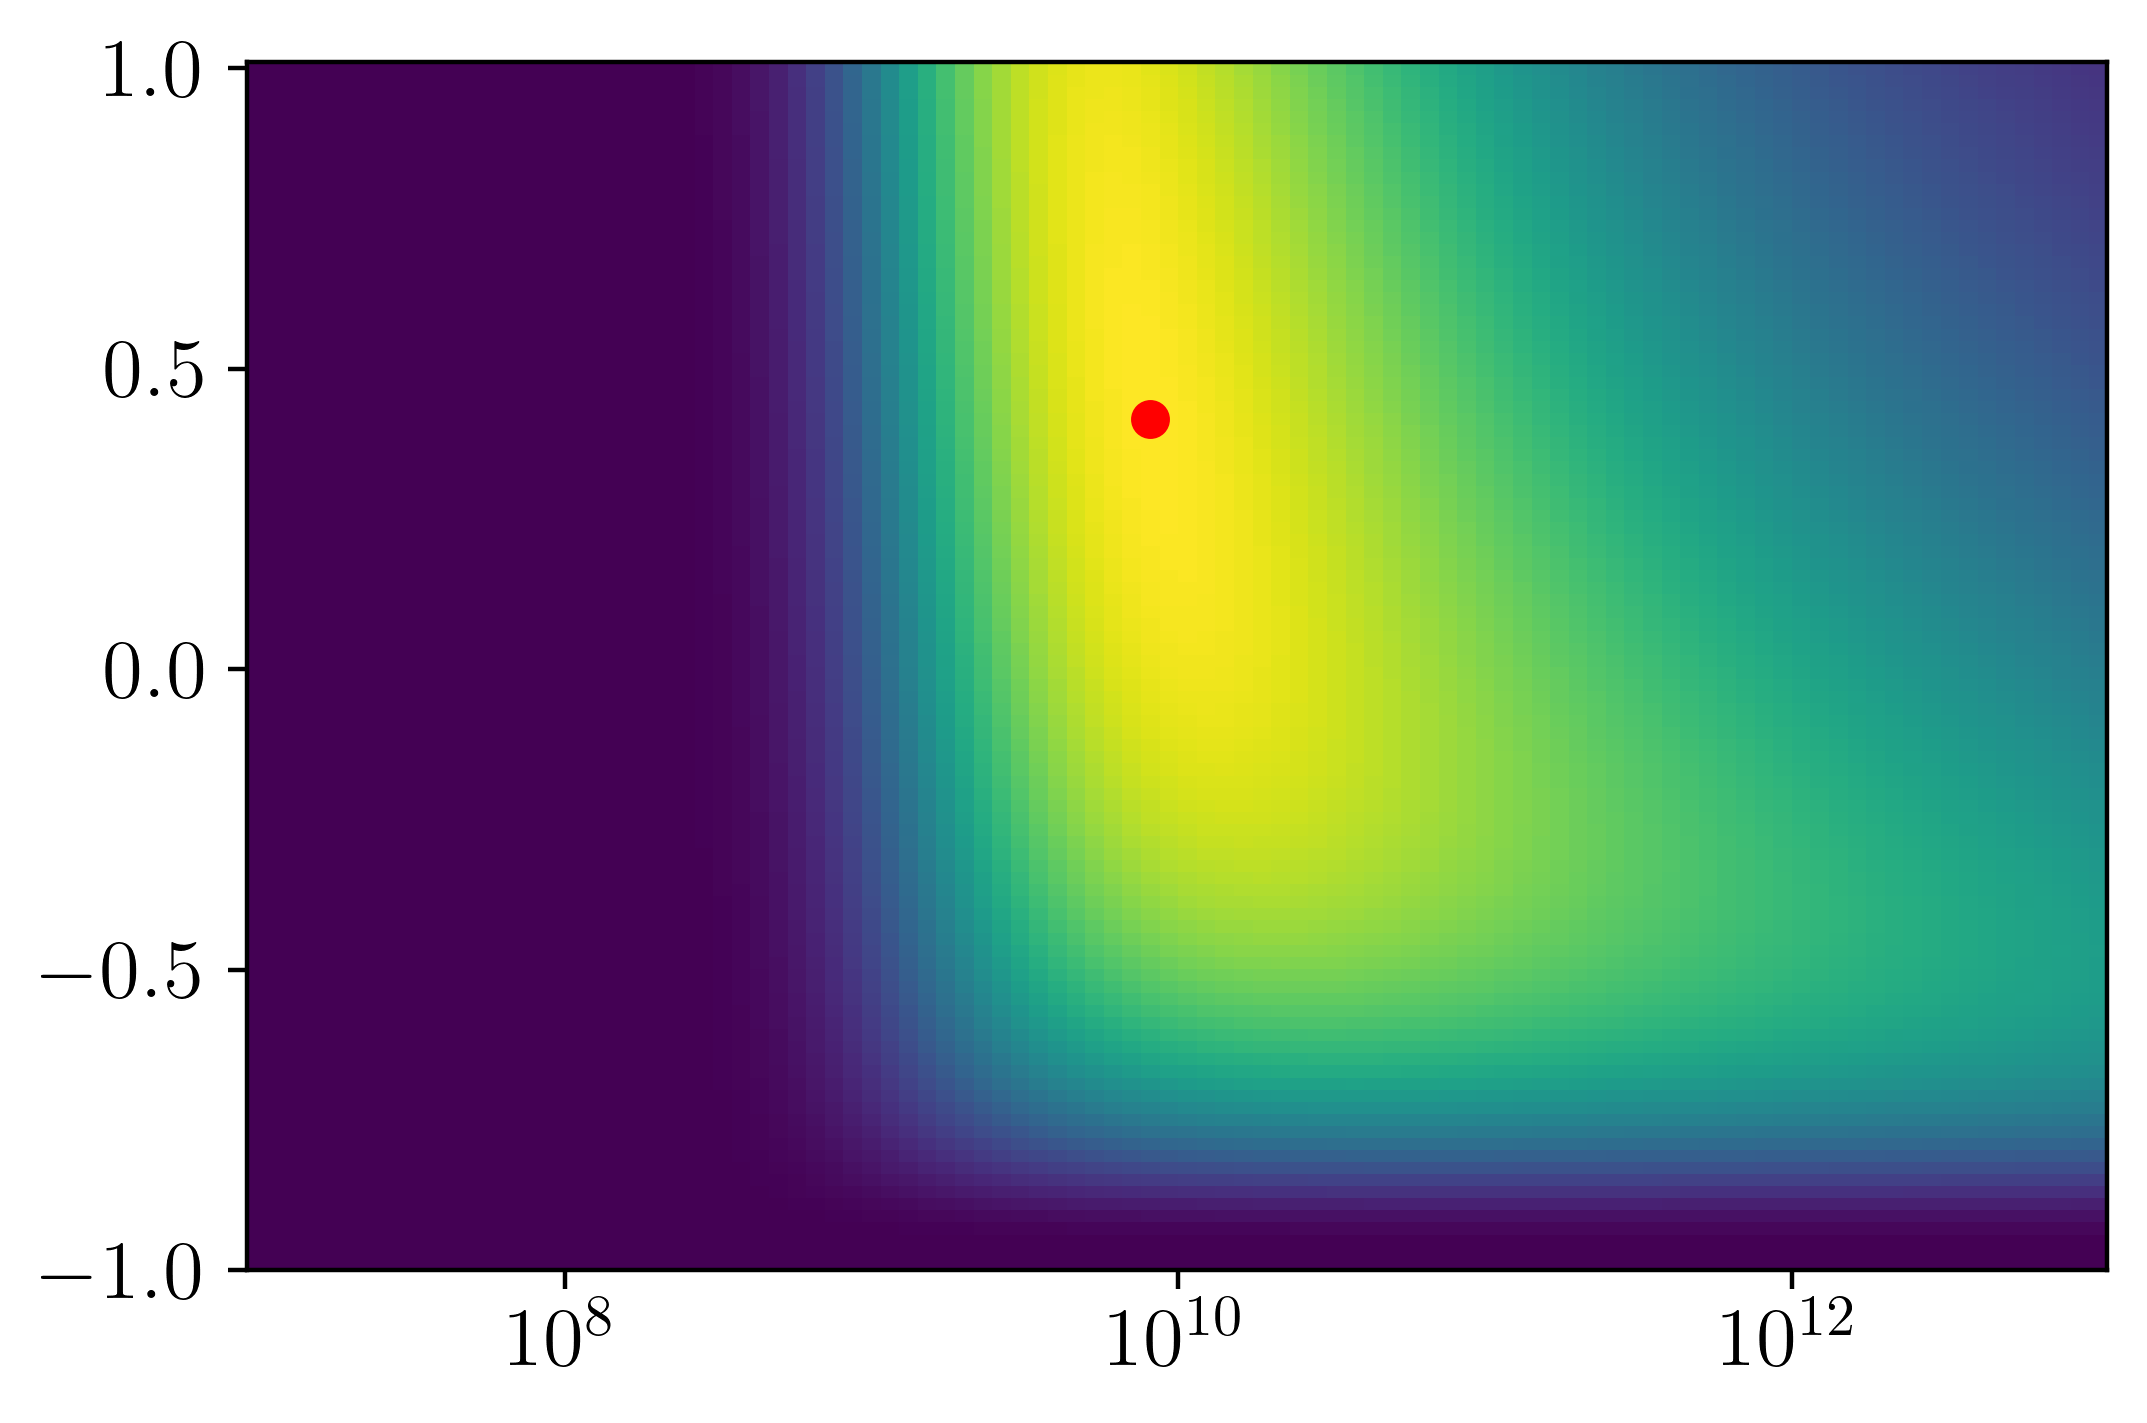

In [123]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
alphas = np.linspace(-0.99, 1., 100)
L_stars = np.logspace(7, 13, 100)
img = ax.pcolor(L_stars, alphas, normalize(R),norm=colors.PowerNorm(gamma=200), shading='auto')
#fig.colorbar(img, ax=ax)
ax.scatter(L_stars[48],alphas[70], color='red')
ax.set_xscale('log')
fig

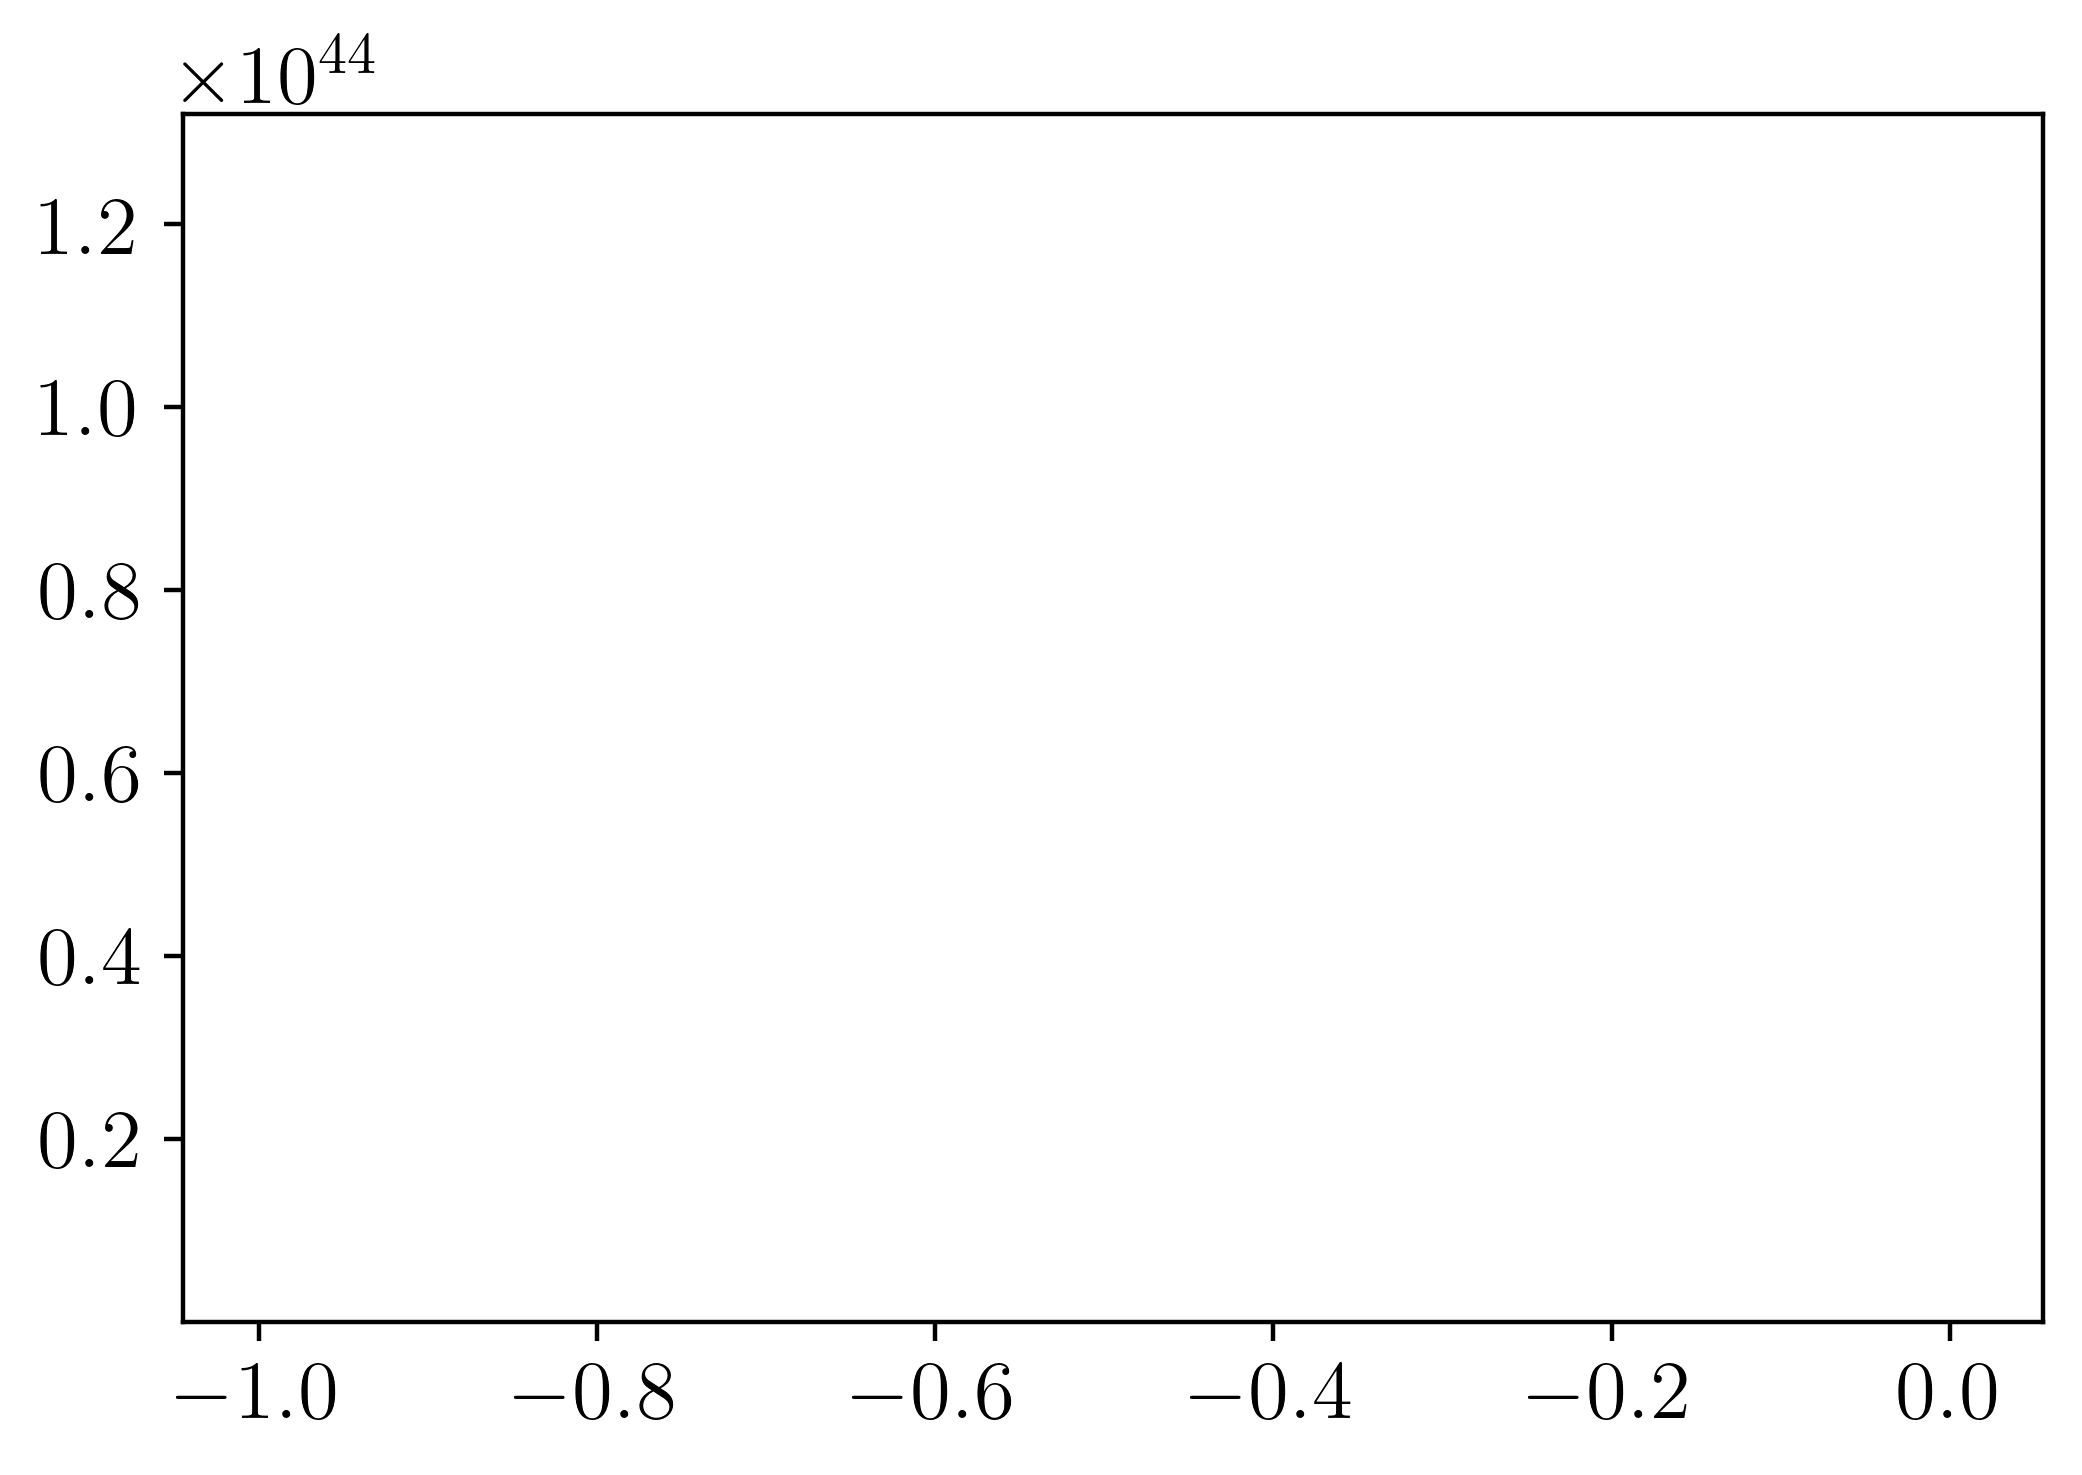

In [146]:
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
res = np.load('res.npy')
fig, ax = plt.subplots(1,1, figsize=(6,4))
img = ax.pcolormesh(np.linspace(-0.99, 0.0, 10), np.logspace(40, 44, 10), np.exp(res6/1e10)/4e2, norm=colors.PowerNorm(gamma=200),
                       cmap='viridis', shading='auto')
fig

In [95]:
fig.savefig("MLE_result.jpeg", dpi=300)

In [89]:
%%timeit
P(-0.99, 1e42, 1e6 * n)

2.47 s ± 60 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [179]:
res0 = (np.exp(res/1e10+27)/4e2)[::-1, :]

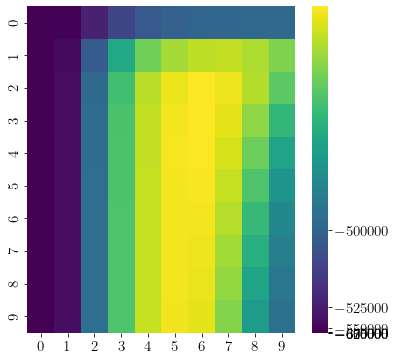

In [142]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.heatmap(res6/1e3, cmap=mpl.cm.viridis, norm=colors.PowerNorm(gamma=9), ax = ax)
fig